In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

### Toward Reservoir Oil Viscosity Correlation 


### PVT корреляция:

$\mu_o = \mu_{ob} + (P - P_b) (a_1 (\frac{\mu_{ob}}{P_b})^{a_2} + a_3 (\frac{\mu_{ob}}{P_b})^{a_4} + a_5 \mu_{ob}^{(a_6 P_b + a_7)} )$ 

Коэффициенты:

a1 = 0.0007376096

a2 = 0.3895556

a3 = 0.2444663

a4 = 1.226398

a5 = 0.00000560643

a6 = 0.001254195

a7 = 0.3026506

In [258]:
def undersaturated_viscosity_correlation (P, mu_ob, Pb,):
    a1 = 0.0007376096
    a2 = 0.3895556
    a3 = 0.2444663
    a4 = 1.226398
    a5 = 0.00000560643
    a6 = 0.001254195
    a7 = 0.3026506
    
    viscosity =  mu_ob + (P - Pb) * ((a1 * (mu_ob / Pb)**a2 + a3* (mu_ob / Pb)**a4) + a5 * mu_ob ** (a6* Pb + a7))
    return viscosity

Pressure, viscosity = initial_conditions()

undersaturated_viscosity_correlation(Pressure, 170.49478912353516, 862.5091247558594)


tensor([156.0293, 158.9853, 164.8974, 170.8094, 176.7215, 181.4511, 188.5455,
        194.4576, 200.3696, 206.2817, 212.1937, 218.1058, 224.0178, 225.9896])

## Regression of PVT Correlation

In [216]:
def initial_conditions():
    '''
    Gathered from PVDO table
    '''
    
    Pressure = torch.tensor([35, 40, 50, 60, 70, 78.00008331, 90, 100, 110, 120, 130, 140, 150, 153.3351982])
    Pressure = Pressure * 14.5038 # From Bar to PSIA 
    viscosity = torch.tensor([179.9237102, 181.4609429, 184.536527, 187.6133261,190.6910172, 193.1536272, 196.8478322, 199.9263582,\
                           203.0045801, 206.0822214, 209.1590145, 212.2346999, 215.3090263, 216.3340305 ])

    return Pressure, viscosity

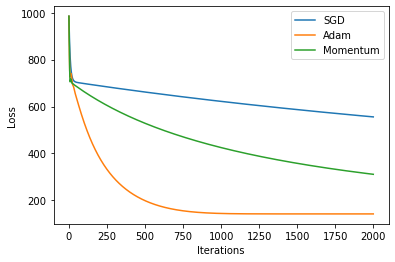

After training with optimizer: tensor([160.1735, 163.2211, 169.3163, 175.4116, 181.5068, 186.3831, 193.6973,
        199.7925, 205.8878, 211.9830, 218.0782, 224.1735, 230.2687, 232.3016],
       grad_fn=<AddBackward0>)
Result: mu_ob = 174.11444091796875 cp ; p_b = 839.362060546875 psia


,SGD,Adam,SGD with Momentum
0,985.1216,985.1216,985.1216
1,953.2914,919.86786,953.2914
2,925.0507,864.2218,902.3957
3,900.00055,818.3973,845.6122
4,877.7843,782.4308,793.4785
...,...,...,...
1995,556.027,141.95763,311.24228
1996,555.9684,141.95761,311.16266
1997,555.9097,141.95766,311.08325
1998,555.8511,141.95758,311.00394


In [243]:
# Параметры x и y
x, y = initial_conditions()

class Linear(nn.Module):
    
    def __init__(self,  bias=True):
        
        super().__init__()

        # Tune parameters manually: a - mu_ob; b - p_ob
        self.a = torch.nn.Parameter(torch.tensor([115.]))

        self.b = torch.nn.Parameter(torch.tensor([25* 14.5038]))
                                                                                                                                
    def forward(self, Pressure):
        # a = mu_ob and b = Pb
                                                                                                                                 
        predicted_viscosity = self.a + (Pressure - self.b) * ((0.0007376096 * (self.a/self.b)**0.3895556) + (0.2444663* (self.a/self.b)**1.226398) + (0.00000560643 * self.a ** (0.001254195 * self.b + 0.3026506)))
        
        return predicted_viscosity

    def string(self):
        """
        To print the coefficient values
        """
        return (f'mu_ob = {self.a.item()} cp ; p_b = {self.b.item()} psia')

# Defning models for SGD, Adam and Momentum
model_SGD = Linear()   
model_Adam = Linear()
model_Momentum = Linear()
models = [model_SGD, model_Adam, model_Momentum]

# Comparing SGD, Adam and SGD with Momentum Optimizerrs
def train(number_of_iterations):

    # Define Optimizer
    optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr= 0.01)
    optimizer_Adam = torch.optim.Adam(model_Adam.parameters(), lr = 1.1 )
    optimizer_Momentum = torch.optim.SGD(model_Momentum.parameters(), lr = 0.01, momentum = 0.8)
    optimizers = [optimizer_SGD, optimizer_Adam, optimizer_Momentum]

    # My parameters: mu_ob = 150 cp and P_b = 290 psia (20 bar)
#     print('Before training with my parameters:', model_SGD(x))

    losses =  [[], [], []]

    for t in range(number_of_iterations):

        for model, optimizer, loss_list in zip(models, optimizers, losses):

            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(x)

            # L2 - норма loss функции 
            loss = (y - y_pred).pow(2).mean()

            if t % 100 == 99:
                pass
#                 print(t, loss.item())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data.numpy())

    labels = ['SGD', 'Adam', 'Momentum']

    
    return losses, labels


losses, labels = train(2000)

for i, loss in enumerate(losses):
    plt.plot(loss, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


# Loss Table 
def Loss_Function_Tabular(loss_function):
    import pandas as pd 
    Adam_Optimizer = pd.Series(loss_function[1])
    SGD_Optimizer = pd.Series(loss_function[0])
    SGD_Momentum_Optimizer = pd.Series(loss_function[2])

    frame = {'SGD': SGD_Optimizer, 'Adam': Adam_Optimizer, 'SGD with Momentum': SGD_Momentum_Optimizer}

    return pd.DataFrame(frame)


# Trained Models
print('After training with optimizer:', model_Adam(Pressure))
print(f'Result: {model_Adam.string()}')


results = Loss_Function_Tabular(losses)
results

## Normalization Method #1

In [248]:
def log_transformation(data):
    
    '''
    Normalizes data in the following procedure: Takes the standard deviation of difference between log and mean 
    of an input variable (tensor). Then standard deviation is divided by log of input variable (tensor)  
    '''
    data_log = torch.log(data)
    data_mean = torch.mean(data)
    Standard_Deviation = torch.std(data_log - data_mean)
    return (data_log/Standard_Deviation)


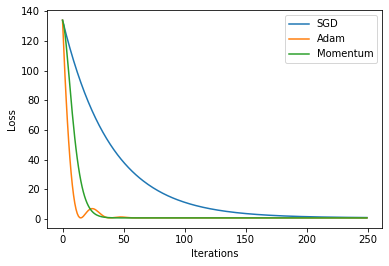

After training with optimizer: tensor([82.4551, 82.4701, 82.4951, 82.5155, 82.5327, 82.5448, 82.5609, 82.5727,
        82.5833, 82.5931, 82.6020, 82.6103, 82.6180, 82.6205],
       grad_fn=<AddBackward0>)
Result: mu_ob = 100.59330749511719 cp ; p_b = 343.5506286621094 psia


,SGD,Adam,SGD with Momentum
0,133.88638,133.88638,133.88638
1,130.56717,114.42345,130.56717
2,127.33022,96.540146,124.737724
3,124.173485,80.2605,117.13495
4,121.09504,65.59945,108.39555
...,...,...,...
245,1.0930593,0.83168876,0.83768207
246,1.0865952,0.8316813,0.83768207
247,1.0802929,0.83167213,0.83768207
248,1.0741528,0.83166486,0.83768207


In [272]:
# Параметры x и y
Pressure, viscosity = initial_conditions()

x = log_transformation(Pressure)
y = log_transformation(viscosity)


class Linear(nn.Module):
    
    def __init__(self,  bias=True):
        
        super().__init__()

        # Tune parameters manually: a - mu_ob; b - p_ob
        self.a = torch.nn.Parameter(torch.tensor([115.]))

        self.b = torch.nn.Parameter(torch.tensor([25* 14.5038]))
                                                                                                                                
    def forward(self, Pressure):
        # a = mu_ob and b = Pb
        
        Pressure = log_transformation(Pressure)                                                                                                                         
        predicted_viscosity = self.a + (Pressure - self.b) * ((0.0007376096 * (self.a/self.b)**0.3895556) + (0.2444663* (self.a/self.b)**1.226398) + (0.00000560643 * self.a ** (0.001254195 * self.b + 0.3026506)))
        
        return predicted_viscosity

    def string(self):
        """
        To print the coefficient values
        """
        return (f'mu_ob = {self.a.item()} cp ; p_b = {self.b.item()} psia')

# Defning models for SGD, Adam and Momentum
model_SGD = Linear()   
model_Adam = Linear()
model_Momentum = Linear()
models = [model_SGD, model_Adam, model_Momentum]

# Comparing SGD, Adam and SGD with Momentum Optimizerrs
def train(number_of_iterations):

    # Define Optimizer
    optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr= 0.01)
    optimizer_Adam = torch.optim.Adam(model_Adam.parameters(), lr = 1.1 )
    optimizer_Momentum = torch.optim.SGD(model_Momentum.parameters(), lr = 0.01, momentum = 0.8)
    optimizers = [optimizer_SGD, optimizer_Adam, optimizer_Momentum]

    # My parameters: mu_ob = 150 cp and P_b = 290 psia (20 bar)
#     print('Before training with my parameters:', model_SGD(x))

    losses =  [[], [], []]

    for t in range(number_of_iterations):

        for model, optimizer, loss_list in zip(models, optimizers, losses):

            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(x)

            # L2 - норма loss функции 
            loss = (y - y_pred).pow(2).mean()

            if t % 100 == 99:
                pass
#                 print(t, loss.item())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data.numpy())

    labels = ['SGD', 'Adam', 'Momentum']

    
    return losses, labels


losses, labels = train(250)

# Plot of three optimization algorithms 
for i, loss in enumerate(losses):
    plt.plot(loss, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


# Loss Table 
def Loss_Function_Tabular(loss_function):
    import pandas as pd 
    Adam_Optimizer = pd.Series(loss_function[1])
    SGD_Optimizer = pd.Series(loss_function[0])
    SGD_Momentum_Optimizer = pd.Series(loss_function[2])

    frame = {'SGD': SGD_Optimizer, 'Adam': Adam_Optimizer, 'SGD with Momentum': SGD_Momentum_Optimizer}

    return pd.DataFrame(frame)


# Trained Models
print('After training with optimizer:', model_Adam(Pressure))
print(f'Result: {model_Adam.string()}')



results = Loss_Function_Tabular(losses)
results